In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
BC = load_breast_cancer()

In [4]:
BC.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [5]:
X = BC.data[:,:2]
y = BC.target
dataset = []
for i in range(len(X)):
    dataset.append(np.append(X[i],y[i]))

In [6]:
malignent=BC.data[y==1]
benign=BC.data[y==0]

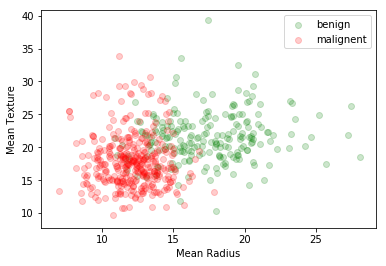

In [7]:
xb,yb=benign[:,0],benign[:,1]
xm,ym=malignent[:,0],malignent[:,1]
plt.scatter(xb,yb,color='g',alpha=0.2,label='benign')
plt.scatter(xm,ym,color='r',alpha=0.2,label='malignent')
plt.legend()
plt.xlabel("Mean Radius")
plt.ylabel("Mean Texture")
plt.show()

Setting up tree functions for splitting

In [8]:
def split(index,value,data):
    """Given a threshold value, perform a split on the data in 2 parts."""
    split1 = []
    split2 = []
    for row in data:
        if row[index] < value:
            split1.append(row)
        else:
            split2.append(row)
    return split1, split2

def gini(groups,classes):
    """Calculates the gini score for a given splitting choice.
        The score indicates how good the split is by calculating the proportion of correctly subdivided classes.
        A score is between 0 and 1, with 0 being the best."""
    total = sum([len(group) for group in groups])
    gini = 0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0
        for class_value in classes:
            proportion = [row[-1] for row in group].count(class_value) / size
            score += proportion*proportion 
        gini += (1.0 - score) * (size / total) 
    return gini


def find_split(data):
    """Iterates through different splits to find the optimum splitting given the gini score."""
    class_values = set(row[-1] for row in data)
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(data[0])-1):
        for row in data:
            groups = split(index,row[index],data)
            gini_score = gini(groups,class_values)
            #print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini_score))
            if gini_score < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini_score, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

Growing the tree

In [9]:
def terminal_value(group):
    """Given the values at a final (terminal) node, calculates the chosen value (i.e. most likely occuring value)"""
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key = outcomes.count)

def child_split(node,max_depth,min_size,depth):
    """Splits the node into child nodes. Inputs:
        node: current working node,
        max_depth: user specified maximum cutoff depth of tree,
        min_size: user specified minimum depth of tree,
        depth: current working depth."""
    
    split1, split2 = node['groups']
    del(node['groups'])
    
    #check if splits are empty
    if len(split1) == 0 or len(split2) == 0:
        node['split1'] = node['split2'] = terminal_value(split1 + split2)
        return
    
    #check max depth
    if depth >= max_depth:
        node['split1'], node['split2'] = terminal_value(split1), terminal_value(split2)
        return
    
    #split1
    if len(split1) <= min_size:
        node['split1'] = terminal_value(split1)
    else:
        node['split1'] = find_split(split1)
        child_split(node['split1'],max_depth,min_size,depth+1)
    
    #split2
    if len(split2) <= min_size:
        node['split2'] = terminal_value(split2)
    else:
        node['split2'] = find_split(split2)
        child_split(node['split2'],max_depth,min_size,depth+1)

Build the tree

In [10]:
def build(train,max_depth,min_size):
    """Builts the decision tree."""
    
    #create root node from which to split
    root = find_split(train)
    child_split(root,max_depth,min_size,depth=1)
    return root

In [11]:
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['split1'], depth+1)
		print_tree(node['split2'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))

Predict outcomes

In [12]:
def predict(node, row):
    """Predicts the class given a row of data by following a path through the tree until terminal nodes are reached."""
    #check data values against threshold
    if row[node['index']] < node['value']:
        #check if split1 node is in a nodal dictionary or if it is a terminal node
        if isinstance(node['split1'], dict):
            return predict(node['split1'], row)
        else:
            #if temrinal node, then split1 will have the terminal value assigned by the child_split function
            return node['split1']
    
    #check if split2 node is in a nodal dictionary or if it is a terminal node
    else:
        if isinstance(node['split2'], dict):
            return predict(node['split2'], row)
        else:
            #if temrinal node, then split2 will have the terminal value assigned by the child_split function
            return node['split2']

Define the accuracy of the model

In [13]:
def accuracy(target, prediction):
    """Calculates the accuracy of the model."""
    correct = 0
    for i in range(len(target)):
        if target[i] == prediction [i]:
            correct += 1
    accuracy = (correct / (len(target)))
    return accuracy

Test on the data

In [14]:
train = dataset[:500]
test = dataset[500:569]
target = [row[-1] for row in test]

In [15]:
def decision_tree(train,test,max_depth,min_size):
    """Builds a decision tree and predicts the outcomes of test data, given training data"""
    tree = build(train,max_depth,min_size)
    predictions = []
    for row in test:
        predictions.append(predict(tree,row))
    return predictions

In [16]:
predictions = decision_tree(train,test,10,1)

In [17]:
print (accuracy(target,predictions))

0.8405797101449275


For more information: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/